In [1]:
import pandas as pd
import findspark
from pyspark.sql import SparkSession
from pyspark import SparkConf

# for dataframe and udf
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *


from pyspark.sql.functions import col
from pyspark.sql import functions as F

from igraph import Graph
from pyspark.sql.window import Window
from pyspark.sql.functions import col

from functools import reduce
from pyspark.sql.functions import collect_set, min as min_, expr,array_min,max
from pyspark.sql.functions import lit

from pyspark.sql.types import StringType, IntegerType, LongType, FloatType, ArrayType,StructType,StructField, BooleanType

import pandas as pd
import glob

import time

import matplotlib.pyplot as plt

from pyspark.sql.types import BooleanType


In [2]:
import os
os.environ["SPARK_HOME"] =  "/root/anaconda3/lib/python3.9/site-packages/pyspark" 
os.environ["JAVA_HOME"] ="/usr"

# Lancer spark

In [3]:
findspark.init() 

def demarrer_spark(NB_CORES):
  local = f"local[{NB_CORES}]"
  # le parametre spark.local.dir indique le repertoire contenant les données temporaires ecrites sur disque lorsque le shufle ne tient pas en memoire
  appName = "PLDAC"
  configLocale = SparkConf().setAppName(appName).setMaster(local).\
  set("spark.executor.memory", "320G").\
  set("spark.driver.memory","320G").\
  set("spark.sql.catalogImplementation","in-memory").\
  set("spark.driver.maxResultSize", "20G").\
  set("spark.local.dir", "/data/bd/spark/tmp").\
  set("spark.sql.execution.arrow.pyspark.enabled", "true")
    

# # to allow sharing in memory arow format between pandas and spark : speeds up the creation of a spark df from a pandas df
# spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")


  spark = SparkSession.builder.config(conf = configLocale).getOrCreate()
  sc = spark.sparkContext
  sc.setLogLevel("ERROR")
  
  # spark.conf.set("spark.sql.autoBroadcastJoinThreshold","-1")
    
  # On ajuste l'environnement d'exécution des requêtes à la taille du cluster (NB_CORES coeurs)
  shuffle_partitions = 3 * NB_CORES
  print("shuffle", shuffle_partitions)
  spark.conf.set("spark.sql.shuffle.partitions", str(shuffle_partitions))    

  print("session démarrée, son id est ", sc.applicationId)
  return spark


In [4]:
def calculate_partition_components(partition_folder , nb_partition):
   
    def components(partition_file, num_file , d) :
        # print(partition_file)
        df = pd.read_parquet(partition_file )
        g = Graph.TupleList(df[['query_id', 'target_id']].itertuples(index=False), directed=False)
        connected_components = g.connected_components()
        node_ids=[]
        for component in connected_components:
            node_ids.append([g.vs[node_index]['name'] for node_index in component])
        #on trie en fonction de la taille 
        composantes_triees = sorted(node_ids, key=len, reverse=True)
        # Créer une liste de lignes pour chaque composante
        rows = []
        for i, component in enumerate(composantes_triees):
            for seqid in component:
                rows.append((seqid , i)) 
        # result_df = pd.DataFrame(rows, columns=['seqid', 'component'])
        # file_path = f"/data/bd/dataset/proteine/80_80/G99/graph_partitionned_components/200_partitions_components/partition_{num_file}.parquet"
        # result_df.to_parquet(file_path, index=False)

        return rows

    # Schéma du DataFrame
    schema = StructType([
        StructField("file", StringType(), False)
    ])
    
    # Données à partir desquelles créer le DataFrame
    # data = [(file,) for file in os.listdir(partition_folder)]
    # data = [(i,) for i, file in enumerate(os.listdir(partition_folder))]
    data = [(i,) for i in range(nb_partition)]

    # Création du DataFrame
    df = spark.createDataFrame(data, schema).repartition(nb_partition)
    # Enregistrer la fonction UDF
    schema_components = StructType([
        StructField("seqID", StringType(), nullable=False),
        StructField("component_id", IntegerType(), nullable=False)
    ])
    components_udf = F.udf(components, ArrayType(schema_components))
    #df_with_components = df.withColumn("components", components_udf(F.concat(F.lit(partition_folder+"/"), df["file"])))
    df_with_components = df.withColumn(
        "components",
        components_udf(
            F.concat(
                F.lit(partition_folder + "/partition_"), 
                df["file"] , 
                F.lit(".parquet")
            ) , 
            df["file"],
            F.lit(nb_partition)
        )
    )
    
    return df_with_components

In [5]:
from igraph import Graph

def components_2(edges):
    # Créer un graphe à partir des arêtes
    g = Graph.TupleList(edges, directed=False)
    
    connected_components = g.connected_components()
    node_ids=[]
    for component in connected_components:
        node_ids.append([g.vs[node_index]['name'] for node_index in component])
    #on trie en fonction de la taille 
    composantes_triees = sorted(node_ids, key=len, reverse=True)
    # Créer une liste de lignes pour chaque composante
    rows = []
    for i, component in enumerate(composantes_triees):
        for seqid in component:
            rows.append(Row(partial_component=seqid ,component=i ))
    
    # Créer un DataFrame Spark à partir de la liste de lignes
    result_df = spark.createDataFrame(rows)
    
    return result_df

In [6]:
spark = demarrer_spark(60)

24/04/28 02:27:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/28 02:27:47 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
24/04/28 02:27:48 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/04/28 02:27:48 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


shuffle 180
session démarrée, son id est  local-1714264068664


In [13]:
times_Gprime_moy_total=[2471.6794362068176, 1194.6440687179565]
times_moy_total=[4585.95818400383, 2147.652998447418]


"""
times_Gprime_moy_total [2471.6794362068176, 1194.6440687179565]
times_moy_total [4585.95818400383, 2147.652998447418]
"""
nb_partitions = [70,100,150]
for num_partitions in nb_partitions :
    print("Avec un nombre de partitions égale à : ",num_partitions)
    start_time = time.time()

    partition_folder = f"/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/partitions/{num_partitions}_partitions"
    print("here :: ",partition_folder)
    df_with_components = calculate_partition_components(partition_folder,num_partitions)

    df_exploded = df_with_components.select('file',  F.explode('components').alias('component'))
    df_split = df_exploded.select("file", col("component.seqID").alias("seqID"), col("component.component_id").alias("component_id"))

    # # Ajouter une colonne d'identifiant unique basée sur le couple (file, component_id)
    windowSpec = Window.orderBy("file", "component_id")
    df = df_split.withColumn("new_component_id", dense_rank().over(windowSpec))
    new_df = df.select("seqID","new_component_id")


    components_per_node = new_df \
        .groupby("seqID") \
        .agg(collect_set("new_component_id").alias("components")) \
        .withColumn("min_component", array_min("components"))


    components_per_node_exploded = components_per_node.select('seqID', 'min_component', F.explode('components').alias('component'))
    result = components_per_node_exploded.where(col("component") > col("min_component")).drop("seqID").dropDuplicates()


    new_graph = result.withColumnRenamed("min_component", "src").withColumnRenamed("component", "dst")


    new_graph.select('src', 'dst').write.csv(f'/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/20_50_70_150_G_prime_time_comp/{num_partitions}_part_graphe_60_G_prime.csv')

    #--------------------
    edges = spark.read.csv(f'/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/20_50_70_150_G_prime_time_comp/{num_partitions}_part_graphe_60_G_prime.csv', header=False, inferSchema=True)

    # Création du graph avec igraph
    from igraph import Graph

    # Conversion des arêtes DataFrame en liste de tuples
    edges_list = edges.rdd.map(lambda row: (row[0], row[1])).collect()

    start_timeG = time.time()

    #___________
    composantes_df = components_2(edges_list)
    composantes_df_exploded = composantes_df \
    .groupby("component") \
    .agg(collect_set("partial_component").alias("partial_components")) \
    .withColumn("min_partial_component", array_min("partial_components")) \
    .selectExpr("explode(partial_components) as partial_component" , "min_partial_component")

    # #resultat final en faisant une jointure gauche
    result = components_per_node.join(composantes_df_exploded, components_per_node.min_component == composantes_df_exploded.partial_component, "left_outer") \
               .select(components_per_node.seqID, when(composantes_df_exploded.partial_component.isNull(), components_per_node.min_component).otherwise(composantes_df_exploded.min_partial_component).alias("new_component_id"))


    #ecriture du résultat dans des fichier parquet
    file_path = f"/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/composantes_finales_test_temps_23_avril"
    result.write.mode("overwrite").parquet(file_path)

    times_Gprime_moy_total.append(time.time() - start_timeG)
    times_moy_total.append(time.time() - start_time)
    print("G prime ",times_Gprime_moy_total)
    print("Time total   ",times_moy_total)

    stop_time_total = time.time()-start_time

    print("Durée : ",stop_time_total)

Avec un nombre de partitions égale à :  70
here ::  /data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/partitions/70_partitions


G prime  [2471.6794362068176, 1194.6440687179565, 1063.8501031398773]
Time total    [4585.95818400383, 2147.652998447418, 1843.6668572425842]
Durée :  1843.667141199112
Avec un nombre de partitions égale à :  100
here ::  /data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/partitions/100_partitions


G prime  [2471.6794362068176, 1194.6440687179565, 1063.8501031398773, 1045.029902458191]
Time total    [4585.95818400383, 2147.652998447418, 1843.6668572425842, 1755.5635607242584]
Durée :  1755.5638461112976
Avec un nombre de partitions égale à :  150
here ::  /data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/partitions/150_partitions


G prime  [2471.6794362068176, 1194.6440687179565, 1063.8501031398773, 1045.029902458191, 1057.8321268558502]
Time total    [4585.95818400383, 2147.652998447418, 1843.6668572425842, 1755.5635607242584, 1793.3706398010254]
Durée :  1793.3708143234253


In [14]:
print("times_Gprime_moy_total",times_Gprime_moy_total)
print("times_moy_total",times_moy_total)


times_Gprime_moy_total [2471.6794362068176, 1194.6440687179565, 1063.8501031398773, 1045.029902458191, 1057.8321268558502]
times_moy_total [4585.95818400383, 2147.652998447418, 1843.6668572425842, 1755.5635607242584, 1793.3706398010254]


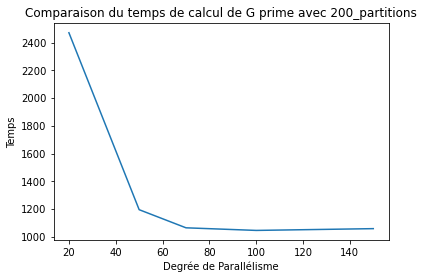

In [16]:
degree_parallelisme = [20,50,70,100,150]
plt.plot(degree_parallelisme, times_Gprime_moy_total)

plt.xlabel('Degrée de Parallélisme')
plt.ylabel('Temps')
plt.title('Comparaison du temps de calcul de G prime avec 200_partitions') 

plt.show()

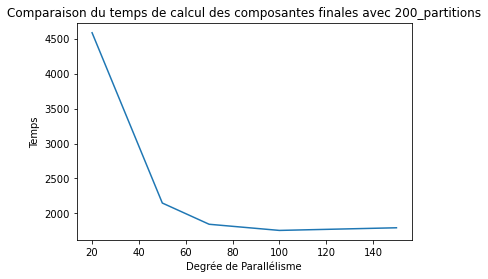

In [17]:
plt.plot(degree_parallelisme, times_moy_total)

plt.xlabel('Degrée de Parallélisme')
plt.ylabel('Temps')
plt.title('Comparaison du temps de calcul des composantes finales avec 200_partitions') 

plt.show()

### Test 29 avril avec 500 partitions : 

In [9]:
spark = demarrer_spark(60)

shuffle 180
session démarrée, son id est  local-1714380608043


In [10]:
num_partitions= 500
start_time = time.time()

partition_folder = f"/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/partitions/{num_partitions}_partitions"
print("here : ",partition_folder)
df_with_components = calculate_partition_components(partition_folder,60)

df_exploded = df_with_components.select('file',  F.explode('components').alias('component'))
df_split = df_exploded.select("file", col("component.seqID").alias("seqID"), col("component.component_id").alias("component_id"))

# # Ajouter une colonne d'identifiant unique basée sur le couple (file, component_id)
windowSpec = Window.orderBy("file", "component_id")
df = df_split.withColumn("new_component_id", dense_rank().over(windowSpec))
new_df = df.select("seqID","new_component_id")


components_per_node = new_df \
    .groupby("seqID") \
    .agg(collect_set("new_component_id").alias("components")) \
    .withColumn("min_component", array_min("components"))


components_per_node_exploded = components_per_node.select('seqID', 'min_component', F.explode('components').alias('component'))
result = components_per_node_exploded.where(col("component") > col("min_component")).drop("seqID").dropDuplicates()


new_graph = result.withColumnRenamed("min_component", "src").withColumnRenamed("component", "dst")


new_graph.select('src', 'dst').write.csv(f'/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/20_50_70_150_G_prime_time_comp/{num_partitions}_part_graphe_60_G_prime.csv')

#--------------------
edges = spark.read.csv(f'/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/20_50_70_150_G_prime_time_comp/{num_partitions}_part_graphe_60_G_prime.csv', header=False, inferSchema=True)

# Création du graph avec igraph
from igraph import Graph

# Conversion des arêtes DataFrame en liste de tuples
edges_list = edges.rdd.map(lambda row: (row[0], row[1])).collect()

start_timeG = time.time()

#___________
composantes_df = components_2(edges_list)
composantes_df_exploded = composantes_df \
.groupby("component") \
.agg(collect_set("partial_component").alias("partial_components")) \
.withColumn("min_partial_component", array_min("partial_components")) \
.selectExpr("explode(partial_components) as partial_component" , "min_partial_component")

# #resultat final en faisant une jointure gauche
result = components_per_node.join(composantes_df_exploded, components_per_node.min_component == composantes_df_exploded.partial_component, "left_outer") \
           .select(components_per_node.seqID, when(composantes_df_exploded.partial_component.isNull(), components_per_node.min_component).otherwise(composantes_df_exploded.min_partial_component).alias("new_component_id"))


#ecriture du résultat dans des fichier parquet
file_path = f"/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/composantes_finales_test_temps_23_avril"
result.write.mode("overwrite").parquet(file_path)
stop_time_total = time.time()-start_time
stop_time_g_PRIME = time.time()-start_timeG


print("G prime ",stop_time_g_PRIME)
print("Time total   ",stop_time_total)




here :  /data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/partitions/500_partitions


G prime  117.19477224349976
Time total    210.56169748306274


In [13]:
num_partitions= 50
start_time = time.time()

partition_folder = f"/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/partitions/{num_partitions}_partitions"
print("here : ",partition_folder)
df_with_components = calculate_partition_components(partition_folder,50)

df_exploded = df_with_components.select('file',  F.explode('components').alias('component'))
df_split = df_exploded.select("file", col("component.seqID").alias("seqID"), col("component.component_id").alias("component_id"))

# # Ajouter une colonne d'identifiant unique basée sur le couple (file, component_id)
windowSpec = Window.orderBy("file", "component_id")
df = df_split.withColumn("new_component_id", dense_rank().over(windowSpec))
new_df = df.select("seqID","new_component_id")


components_per_node = new_df \
    .groupby("seqID") \
    .agg(collect_set("new_component_id").alias("components")) \
    .withColumn("min_component", array_min("components"))


components_per_node_exploded = components_per_node.select('seqID', 'min_component', F.explode('components').alias('component'))
result = components_per_node_exploded.where(col("component") > col("min_component")).drop("seqID").dropDuplicates()


new_graph = result.withColumnRenamed("min_component", "src").withColumnRenamed("component", "dst")


new_graph.select('src', 'dst').write.csv(f'/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/20_50_70_150_G_prime_time_comp/{num_partitions}_part_graphe_60_G_prime.csv')

#--------------------
edges = spark.read.csv(f'/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/20_50_70_150_G_prime_time_comp/{num_partitions}_part_graphe_60_G_prime.csv', header=False, inferSchema=True)

# Création du graph avec igraph
from igraph import Graph

# Conversion des arêtes DataFrame en liste de tuples
edges_list = edges.rdd.map(lambda row: (row[0], row[1])).collect()

start_timeG = time.time()

#___________
composantes_df = components_2(edges_list)
composantes_df_exploded = composantes_df \
.groupby("component") \
.agg(collect_set("partial_component").alias("partial_components")) \
.withColumn("min_partial_component", array_min("partial_components")) \
.selectExpr("explode(partial_components) as partial_component" , "min_partial_component")

# #resultat final en faisant une jointure gauche
result = components_per_node.join(composantes_df_exploded, components_per_node.min_component == composantes_df_exploded.partial_component, "left_outer") \
           .select(components_per_node.seqID, when(composantes_df_exploded.partial_component.isNull(), components_per_node.min_component).otherwise(composantes_df_exploded.min_partial_component).alias("new_component_id"))


#ecriture du résultat dans des fichier parquet
file_path = f"/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/composantes_finales_test_temps_23_avril"
result.write.mode("overwrite").parquet(file_path)
stop_time_total = time.time()-start_time
stop_time_g_PRIME = time.time()-start_timeG


print("G prime ",stop_time_g_PRIME)
print("Time total   ",stop_time_total)




here :  /data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/partitions/50_partitions


G prime  1175.597425699234
Time total    2071.1763184070587


In [15]:
num_partitions= 50
spark = demarrer_spark(num_partitions)
start_time = time.time()

partition_folder = f"/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/partitions/{num_partitions}_partitions"
print("here : ",partition_folder)
df_with_components = calculate_partition_components(partition_folder,num_partitions)

df_exploded = df_with_components.select('file',  F.explode('components').alias('component'))
df_split = df_exploded.select("file", col("component.seqID").alias("seqID"), col("component.component_id").alias("component_id"))

# # Ajouter une colonne d'identifiant unique basée sur le couple (file, component_id)
windowSpec = Window.orderBy("file", "component_id")
df = df_split.withColumn("new_component_id", dense_rank().over(windowSpec))
new_df = df.select("seqID","new_component_id")


components_per_node = new_df \
    .groupby("seqID") \
    .agg(collect_set("new_component_id").alias("components")) \
    .withColumn("min_component", array_min("components"))


components_per_node_exploded = components_per_node.select('seqID', 'min_component', F.explode('components').alias('component'))
result = components_per_node_exploded.where(col("component") > col("min_component")).drop("seqID").dropDuplicates()


new_graph = result.withColumnRenamed("min_component", "src").withColumnRenamed("component", "dst")


new_graph.select('src', 'dst').write.csv(f'/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/20_50_70_150_G_prime_time_comp/{num_partitions}_part_graphe_60_G_prime.csv')

#--------------------
edges = spark.read.csv(f'/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/20_50_70_150_G_prime_time_comp/{num_partitions}_part_graphe_60_G_prime.csv', header=False, inferSchema=True)

# Création du graph avec igraph
from igraph import Graph

# Conversion des arêtes DataFrame en liste de tuples
edges_list = edges.rdd.map(lambda row: (row[0], row[1])).collect()


g_prime_folder = f'/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/20_50_70_150_G_prime_time_comp/G_prime_folder'
start_timeG = time.time()

#___________
composantes_df = components_2(edges_list)

composantes_df.write.mode("overwrite").parquet(g_prime_folder)
stop_time_g_PRIME = time.time()-start_timeG

composantes_df_exploded = composantes_df \
.groupby("component") \
.agg(collect_set("partial_component").alias("partial_components")) \
.withColumn("min_partial_component", array_min("partial_components")) \
.selectExpr("explode(partial_components) as partial_component" , "min_partial_component")

# #resultat final en faisant une jointure gauche
result = components_per_node.join(composantes_df_exploded, components_per_node.min_component == composantes_df_exploded.partial_component, "left_outer") \
           .select(components_per_node.seqID, when(composantes_df_exploded.partial_component.isNull(), components_per_node.min_component).otherwise(composantes_df_exploded.min_partial_component).alias("new_component_id"))


#ecriture du résultat dans des fichier parquet
file_path = f"/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/composantes_finales_test_temps_23_avril"
result.write.mode("overwrite").parquet(file_path)
stop_time_total = time.time()-start_time


print("G prime ",stop_time_g_PRIME)
print("Time total   ",stop_time_total)

spark.stop()


shuffle 150
session démarrée, son id est  local-1714380608043
here :  /data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/partitions/50_partitions


G prime  370.2670750617981
Time total    2566.8542625904083


In [11]:
num_partitions= 150
spark = demarrer_spark(60)
start_time = time.time()

partition_folder = f"/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/partitions/{num_partitions}_partitions"
print("here : ",partition_folder)
df_with_components = calculate_partition_components(partition_folder,60)

df_exploded = df_with_components.select('file',  F.explode('components').alias('component'))
df_split = df_exploded.select("file", col("component.seqID").alias("seqID"), col("component.component_id").alias("component_id"))

# # Ajouter une colonne d'identifiant unique basée sur le couple (file, component_id)
windowSpec = Window.orderBy("file", "component_id")
df = df_split.withColumn("new_component_id", dense_rank().over(windowSpec))
new_df = df.select("seqID","new_component_id")


components_per_node = new_df \
    .groupby("seqID") \
    .agg(collect_set("new_component_id").alias("components")) \
    .withColumn("min_component", array_min("components"))


components_per_node_exploded = components_per_node.select('seqID', 'min_component', F.explode('components').alias('component'))
result = components_per_node_exploded.where(col("component") > col("min_component")).drop("seqID").dropDuplicates()


new_graph = result.withColumnRenamed("min_component", "src").withColumnRenamed("component", "dst")


new_graph.select('src', 'dst').write.csv(f'/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/20_50_70_150_G_prime_time_comp/{num_partitions}_part_graphe_60_G_prime.csv')

#--------------------
edges = spark.read.csv(f'/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/20_50_70_150_G_prime_time_comp/{num_partitions}_part_graphe_60_G_prime.csv', header=False, inferSchema=True)

# Création du graph avec igraph

# Conversion des arêtes DataFrame en liste de tuples
edges_list = edges.rdd.map(lambda row: (row[0], row[1])).collect()

g_prime_folder = f'/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/20_50_70_150_G_prime_time_comp/G_prime_folder'
start_timeG = time.time()

#___________
composantes_df = components_2(edges_list)

composantes_df.write.mode("overwrite").parquet(g_prime_folder)
stop_time_g_PRIME = time.time()-start_timeG

composantes_df_exploded = composantes_df \
.groupby("component") \
.agg(collect_set("partial_component").alias("partial_components")) \
.withColumn("min_partial_component", array_min("partial_components")) \
.selectExpr("explode(partial_components) as partial_component" , "min_partial_component")

# #resultat final en faisant une jointure gauche
result = components_per_node.join(composantes_df_exploded, components_per_node.min_component == composantes_df_exploded.partial_component, "left_outer") \
           .select(components_per_node.seqID, when(composantes_df_exploded.partial_component.isNull(), components_per_node.min_component).otherwise(composantes_df_exploded.min_partial_component).alias("new_component_id"))


#ecriture du résultat dans des fichier parquet
file_path = f"/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/composantes_finales_test_temps_23_avril"
result.write.mode("overwrite").parquet(file_path)
stop_time_total = time.time()-start_time


print("G prime ",stop_time_g_PRIME)
print("Time total   ",stop_time_total)

spark.stop()


shuffle 180
session démarrée, son id est  local-1714391197415
here :  /data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/partitions/150_partitions


G prime  464.7268805503845
Time total    2229.211688041687


In [8]:
num_partitions= 20
spark = demarrer_spark(20)
start_time = time.time()

partition_folder = f"/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/partitions/{num_partitions}_partitions"
print("here : ",partition_folder)
df_with_components = calculate_partition_components(partition_folder,20)

df_exploded = df_with_components.select('file',  F.explode('components').alias('component'))
df_split = df_exploded.select("file", col("component.seqID").alias("seqID"), col("component.component_id").alias("component_id"))

# # Ajouter une colonne d'identifiant unique basée sur le couple (file, component_id)
windowSpec = Window.orderBy("file", "component_id")
df = df_split.withColumn("new_component_id", dense_rank().over(windowSpec))
new_df = df.select("seqID","new_component_id")


components_per_node = new_df \
    .groupby("seqID") \
    .agg(collect_set("new_component_id").alias("components")) \
    .withColumn("min_component", array_min("components"))


components_per_node_exploded = components_per_node.select('seqID', 'min_component', F.explode('components').alias('component'))
result = components_per_node_exploded.where(col("component") > col("min_component")).drop("seqID").dropDuplicates()


new_graph = result.withColumnRenamed("min_component", "src").withColumnRenamed("component", "dst")


new_graph.select('src', 'dst').write.csv(f'/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/20_50_70_150_G_prime_time_comp/{num_partitions}_part_graphe_60_G_prime.csv')

#--------------------
edges = spark.read.csv(f'/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/20_50_70_150_G_prime_time_comp/{num_partitions}_part_graphe_60_G_prime.csv', header=False, inferSchema=True)

# Création du graph avec igraph

# Conversion des arêtes DataFrame en liste de tuples
edges_list = edges.rdd.map(lambda row: (row[0], row[1])).collect()

g_prime_folder = f'/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/20_50_70_150_G_prime_time_comp/G_prime_folder'
start_timeG = time.time()

#___________
composantes_df = components_2(edges_list)

composantes_df.write.mode("overwrite").parquet(g_prime_folder)
stop_time_g_PRIME = time.time()-start_timeG

composantes_df_exploded = composantes_df \
.groupby("component") \
.agg(collect_set("partial_component").alias("partial_components")) \
.withColumn("min_partial_component", array_min("partial_components")) \
.selectExpr("explode(partial_components) as partial_component" , "min_partial_component")

# #resultat final en faisant une jointure gauche
result = components_per_node.join(composantes_df_exploded, components_per_node.min_component == composantes_df_exploded.partial_component, "left_outer") \
           .select(components_per_node.seqID, when(composantes_df_exploded.partial_component.isNull(), components_per_node.min_component).otherwise(composantes_df_exploded.min_partial_component).alias("new_component_id"))


#ecriture du résultat dans des fichier parquet
file_path = f"/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/composantes_finales_test_temps_23_avril"
result.write.mode("overwrite").parquet(file_path)
stop_time_total = time.time()-start_time


print("G prime ",stop_time_g_PRIME)
print("Time total   ",stop_time_total)

spark.stop()


shuffle 60
session démarrée, son id est  local-1714395912286
here :  /data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/partitions/20_partitions


G prime  343.11279368400574
Time total    4639.943820714951


In [6]:
num_partitions= 60
spark = demarrer_spark(60)
start_time = time.time()

partition_folder = f"/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/partitions/{num_partitions}_partitions"
print("here : ",partition_folder)
df_with_components = calculate_partition_components(partition_folder,60)

df_exploded = df_with_components.select('file',  F.explode('components').alias('component'))
df_split = df_exploded.select("file", col("component.seqID").alias("seqID"), col("component.component_id").alias("component_id"))

# # Ajouter une colonne d'identifiant unique basée sur le couple (file, component_id)
windowSpec = Window.orderBy("file", "component_id")
df = df_split.withColumn("new_component_id", dense_rank().over(windowSpec))
new_df = df.select("seqID","new_component_id")


components_per_node = new_df \
    .groupby("seqID") \
    .agg(collect_set("new_component_id").alias("components")) \
    .withColumn("min_component", array_min("components"))


components_per_node_exploded = components_per_node.select('seqID', 'min_component', F.explode('components').alias('component'))
result = components_per_node_exploded.where(col("component") > col("min_component")).drop("seqID").dropDuplicates()


new_graph = result.withColumnRenamed("min_component", "src").withColumnRenamed("component", "dst")


new_graph.select('src', 'dst').write.csv(f'/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/20_50_70_150_G_prime_time_comp/{num_partitions}_part_graphe_60_G_prime.csv')

#--------------------
edges = spark.read.csv(f'/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/20_50_70_150_G_prime_time_comp/{num_partitions}_part_graphe_60_G_prime.csv', header=False, inferSchema=True)

# Création du graph avec igraph

# Conversion des arêtes DataFrame en liste de tuples
edges_list = edges.rdd.map(lambda row: (row[0], row[1])).collect()

g_prime_folder = f'/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/20_50_70_150_G_prime_time_comp/G_prime_folder'
start_timeG = time.time()

#___________
composantes_df = components_2(edges_list)

composantes_df.write.mode("overwrite").parquet(g_prime_folder)
stop_time_g_PRIME = time.time()-start_timeG

composantes_df_exploded = composantes_df \
.groupby("component") \
.agg(collect_set("partial_component").alias("partial_components")) \
.withColumn("min_partial_component", array_min("partial_components")) \
.selectExpr("explode(partial_components) as partial_component" , "min_partial_component")

# #resultat final en faisant une jointure gauche
result = components_per_node.join(composantes_df_exploded, components_per_node.min_component == composantes_df_exploded.partial_component, "left_outer") \
           .select(components_per_node.seqID, when(composantes_df_exploded.partial_component.isNull(), components_per_node.min_component).otherwise(composantes_df_exploded.min_partial_component).alias("new_component_id"))


#ecriture du résultat dans des fichier parquet
file_path = f"/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/composantes_finales_test_temps_23_avril"
result.write.mode("overwrite").parquet(file_path)
stop_time_total = time.time()-start_time


print("G prime ",stop_time_g_PRIME)
print("Time total   ",stop_time_total)

spark.stop()


24/04/29 18:18:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/29 18:18:15 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
24/04/29 18:18:16 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/04/29 18:18:16 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/04/29 18:18:16 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


shuffle 180
session démarrée, son id est  local-1714407496559
here :  /data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/partitions/60_partitions


G prime  409.04388642311096
Time total    1987.750917673111


In [ ]:
for num_partitions in [30,40]:
    print(num_partitions)
    spark = demarrer_spark(num_partitions)
    start_time = time.time()

    partition_folder = f"/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/partitions/{num_partitions}_partitions"
    print("here : ",partition_folder)
    df_with_components = calculate_partition_components(partition_folder,num_partitions)

    df_exploded = df_with_components.select('file',  F.explode('components').alias('component'))
    df_split = df_exploded.select("file", col("component.seqID").alias("seqID"), col("component.component_id").alias("component_id"))

    # # Ajouter une colonne d'identifiant unique basée sur le couple (file, component_id)
    windowSpec = Window.orderBy("file", "component_id")
    df = df_split.withColumn("new_component_id", dense_rank().over(windowSpec))
    new_df = df.select("seqID","new_component_id")


    components_per_node = new_df \
        .groupby("seqID") \
        .agg(collect_set("new_component_id").alias("components")) \
        .withColumn("min_component", array_min("components"))


    components_per_node_exploded = components_per_node.select('seqID', 'min_component', F.explode('components').alias('component'))
    result = components_per_node_exploded.where(col("component") > col("min_component")).drop("seqID").dropDuplicates()


    new_graph = result.withColumnRenamed("min_component", "src").withColumnRenamed("component", "dst")


    new_graph.select('src', 'dst').write.csv(f'/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/20_50_70_150_G_prime_time_comp/{num_partitions}_part_graphe_60_G_prime.csv')

    #--------------------
    edges = spark.read.csv(f'/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/20_50_70_150_G_prime_time_comp/{num_partitions}_part_graphe_60_G_prime.csv', header=False, inferSchema=True)

    # Création du graph avec igraph

    # Conversion des arêtes DataFrame en liste de tuples
    edges_list = edges.rdd.map(lambda row: (row[0], row[1])).collect()

    g_prime_folder = f'/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/20_50_70_150_G_prime_time_comp/G_prime_folder'
    start_timeG = time.time()

    #___________
    composantes_df = components_2(edges_list)

    composantes_df.write.mode("overwrite").parquet(g_prime_folder)
    stop_time_g_PRIME = time.time()-start_timeG

    composantes_df_exploded = composantes_df \
    .groupby("component") \
    .agg(collect_set("partial_component").alias("partial_components")) \
    .withColumn("min_partial_component", array_min("partial_components")) \
    .selectExpr("explode(partial_components) as partial_component" , "min_partial_component")

    # #resultat final en faisant une jointure gauche
    result = components_per_node.join(composantes_df_exploded, components_per_node.min_component == composantes_df_exploded.partial_component, "left_outer") \
               .select(components_per_node.seqID, when(composantes_df_exploded.partial_component.isNull(), components_per_node.min_component).otherwise(composantes_df_exploded.min_partial_component).alias("new_component_id"))


    #ecriture du résultat dans des fichier parquet
    file_path = f"/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/composantes_finales_test_temps_23_avril"
    result.write.mode("overwrite").parquet(file_path)
    stop_time_total = time.time()-start_time


    print("G prime ",stop_time_g_PRIME)
    print("Time total   ",stop_time_total)

    spark.stop()
    
print( 
"""
pour 10
shuffle 30
session démarrée, son id est  local-1714434792588
here :  /data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/partitions/10_partitions
                                                                                
G prime  318.4092836380005
Time total    6119.700418710709
"""
)

## AUTRES : 

In [ ]:
times_Gprime_moy_total=[2471.6794362068176, 1194.6440687179565]
times_moy_total=[4585.95818400383, 2147.652998447418]


"""
times_Gprime_moy_total [2471.6794362068176, 1194.6440687179565]
times_moy_total [4585.95818400383, 2147.652998447418]
"""
nb_partitions = [70,100,150]
for num_partitions in nb_partitions :
    print("Avec un nombre de partitions égale à : ",num_partitions)
    start_time = time.time()

    partition_folder = f"/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/partitions/{num_partitions}_partitions"
    print("here :: ",partition_folder)
    df_with_components = calculate_partition_components(partition_folder,num_partitions)

    df_exploded = df_with_components.select('file',  F.explode('components').alias('component'))
    df_split = df_exploded.select("file", col("component.seqID").alias("seqID"), col("component.component_id").alias("component_id"))

    # # Ajouter une colonne d'identifiant unique basée sur le couple (file, component_id)
    windowSpec = Window.orderBy("file", "component_id")
    df = df_split.withColumn("new_component_id", dense_rank().over(windowSpec))
    new_df = df.select("seqID","new_component_id")


    components_per_node = new_df \
        .groupby("seqID") \
        .agg(collect_set("new_component_id").alias("components")) \
        .withColumn("min_component", array_min("components"))


    components_per_node_exploded = components_per_node.select('seqID', 'min_component', F.explode('components').alias('component'))
    result = components_per_node_exploded.where(col("component") > col("min_component")).drop("seqID").dropDuplicates()


    new_graph = result.withColumnRenamed("min_component", "src").withColumnRenamed("component", "dst")


    new_graph.select('src', 'dst').write.csv(f'/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/20_50_70_150_G_prime_time_comp/{num_partitions}_part_graphe_60_G_prime.csv')

    #--------------------
    edges = spark.read.csv(f'/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/20_50_70_150_G_prime_time_comp/{num_partitions}_part_graphe_60_G_prime.csv', header=False, inferSchema=True)

    # Création du graph avec igraph
    from igraph import Graph

    # Conversion des arêtes DataFrame en liste de tuples
    edges_list = edges.rdd.map(lambda row: (row[0], row[1])).collect()

    start_timeG = time.time()

    #___________
    composantes_df = components_2(edges_list)
    composantes_df_exploded = composantes_df \
    .groupby("component") \
    .agg(collect_set("partial_component").alias("partial_components")) \
    .withColumn("min_partial_component", array_min("partial_components")) \
    .selectExpr("explode(partial_components) as partial_component" , "min_partial_component")

    # #resultat final en faisant une jointure gauche
    result = components_per_node.join(composantes_df_exploded, components_per_node.min_component == composantes_df_exploded.partial_component, "left_outer") \
               .select(components_per_node.seqID, when(composantes_df_exploded.partial_component.isNull(), components_per_node.min_component).otherwise(composantes_df_exploded.min_partial_component).alias("new_component_id"))


    #ecriture du résultat dans des fichier parquet
    file_path = f"/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/composantes_finales_test_temps_23_avril"
    result.write.mode("overwrite").parquet(file_path)

    times_Gprime_moy_total.append(time.time() - start_timeG)
    times_moy_total.append(time.time() - start_time)
    print("G prime ",times_Gprime_moy_total)
    print("Time total   ",times_moy_total)

    stop_time_total = time.time()-start_time

    print("Durée : ",stop_time_total)

In [ ]:
# start_time2 = time.time()
# start_timeG2 = time.time()

# composantes_df_exploded = composantes_df \
#         .groupby("component") \
#         .agg(collect_set("partial_component").alias("partial_components")) \
#         .withColumn("min_partial_component", array_min("partial_components")) \
#         .selectExpr("explode(partial_components) as partial_component" , "min_partial_component")

# # #resultat final en faisant une jointure gauche
# result = components_per_node.join(composantes_df_exploded, components_per_node.min_component == composantes_df_exploded.partial_component, "left_outer") \
#            .select(components_per_node.seqID, when(composantes_df_exploded.partial_component.isNull(), components_per_node.min_component).otherwise(composantes_df_exploded.min_partial_component).alias("new_component_id"))


# #ecriture du résultat dans des fichier parquet
# file_path = f"/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/composantes_finales_test_temps"
# result.repartition(1).write.mode("overwrite").parquet(file_path)


# stop_timeG2 = time.time()-start_timeG2
# stop_time_total2 = time.time()-start_time2


# print('Le temps total :',stop_timeG2+start_timeG2)
# print('Le temps g prime :',stop_time_total+stop_time_total2)

In [6]:
def calculate_components_bis(folder_partition,d ):    
    # partition_folder = f"/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/200_partitions/"
    df_with_components = calculate_partition_components(folder_partition,d)

    df_exploded = df_with_components.select('file',  F.explode('components').alias('component'))
    df_split = df_exploded.select("file", col("component.seqID").alias("seqID"), col("component.component_id").alias("component_id"))

    # # Ajouter une colonne d'identifiant unique basée sur le couple (file, component_id)
    windowSpec = Window.orderBy("file", "component_id")
    df = df_split.withColumn("new_component_id", dense_rank().over(windowSpec))
    new_df = df.select("seqID","new_component_id")


    components_per_node = new_df \
        .groupby("seqID") \
        .agg(collect_set("new_component_id").alias("components")) \
        .withColumn("min_component", array_min("components"))


    components_per_node_exploded = components_per_node.select('seqID', 'min_component', F.explode('components').alias('component'))
    result = components_per_node_exploded.where(col("component") > col("min_component")).drop("seqID").dropDuplicates()


    new_graph = result.withColumnRenamed("min_component", "src").withColumnRenamed("component", "dst")


    new_graph.select('src', 'dst').write.csv(f'/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/200_part_test_60/200_part_graphe_{d}_G_prime.csv')

    #--------------------
    edges = spark.read.csv(f'/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/200_part_test_60/200_part_graphe_{d}_G_prime.csv', header=False, inferSchema=True)

    # Création du graph avec igraph
    # from igraph import Graph

    # Conversion des arêtes DataFrame en liste de tuples
    edges_list = edges.rdd.map(lambda row: (row[0], row[1])).collect()

    start_timeG = time.time()

    #___________
    composantes_df = components_2(edges_list)
    
    composantes_df_exploded = composantes_df \
        .groupby("component") \
        .agg(collect_set("partial_component").alias("partial_components")) \
        .withColumn("min_partial_component", array_min("partial_components")) \
        .selectExpr("explode(partial_components) as partial_component" , "min_partial_component")

    # #resultat final en faisant une jointure gauche
    result = components_per_node.join(composantes_df_exploded, components_per_node.min_component == composantes_df_exploded.partial_component, "left_outer") \
               .select(components_per_node.seqID, when(composantes_df_exploded.partial_component.isNull(), components_per_node.min_component).otherwise(composantes_df_exploded.min_partial_component).alias("new_component_id"))


    #ecriture du résultat dans des fichier parquet
    # file_path = f"/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/composantes_finales_test_temps"
    # result.write.mode("overwrite").parquet(file_path)

    return result

In [7]:
spark = demarrer_spark(60)

24/04/24 01:58:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/24 01:58:30 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
24/04/24 01:58:31 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/04/24 01:58:31 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


shuffle 180
session démarrée, son id est  local-1713916711821


In [8]:
partition_folder = f"/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/200_partitions/"

In [10]:
start_time = time.time()
df_with_component = calculate_components_bis(partition_folder , 60)

file_path = f"/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/composantes_finales_test_temps"
df_with_component.write.mode("overwrite").parquet(file_path)
print(time.time() - start_time)


#
# There is insufficient memory for the Java Runtime Environment to continue.
# Native memory allocation (mmap) failed to map 19931332608 bytes for committing reserved memory.
# An error report file with more information is saved as:
# /root/PLDAC/hs_err_pid46087.log


OpenJDK 64-Bit Server VM warning: INFO: os::commit_memory(0x00007f4494000000, 19931332608, 0) failed; error='Not enough space' (errno=12)
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.9/site-packages/py4j/java_gateway.py", line 1207, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.9/site-packages/py4j/java_gateway.py", line 1033, in send_command
    response = connection.send_command(command)
  File "/root/anaconda3/lib/python3.9/site-packages/py4j/java_gateway.py", line 1211, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while receiving


Py4JError: An error occurred while calling o282.csv

In [ ]:
degree_parallelisme = range(1,50,10)
times_moy = []

for d in degree_parallelisme:
    spark = demarrer_spark(d)

    times=[]
    
    for i in range(5):
        start_time = time.time()
        df_with_component = calculate_components_bis(partition_folder , d)

        file_path = f"/data/bd/dataset/proteine/80_80/G99/TEST_RACHA_CALCUL_COMPOSANTES/composantes_finales_test_temps"
        result.write.mode("overwrite").parquet(file_path)

        times.append(time.time() - start_time)
        
    times_moy.append(np.mean(times))
    spark.stop()
    
    

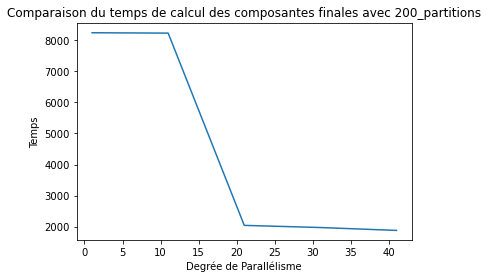

In [20]:
plt.plot(degree_parallelisme, times_moy_total)

plt.xlabel('Degrée de Parallélisme')
plt.ylabel('Temps')
plt.title('Comparaison du temps de calcul des composantes finales avec 200_partitions') 

plt.show()

In [ ]:
spark.stop()